In [1]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import split
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
raw_dataset = pd.read_csv('./station_rio.csv', index_col='YEAR')
raw_dataset.head()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
YEAR,,,,,,,,,,,,,,,,,
1973,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85,27.45,24.87,21.98,22.33,24.16
1974,26.68,27.16,26.56,23.94,22.76,20.70,21.20,21.81,22.91,22.80,24.51,24.54,26.56,24.42,21.24,23.41,23.91
1975,25.27,26.92,26.43,22.82,21.37,20.50,19.68,22.98,22.40,22.65,24.11,26.53,25.58,23.54,21.05,23.05,23.31
1976,27.48,26.20,25.55,24.99,22.01,21.18,20.14,21.15,21.27,22.06,24.40,25.56,26.74,24.18,20.82,22.58,23.58
1977,27.13,28.51,26.88,24.22,22.35,22.13,23.07,22.29,22.44,23.92,24.48,24.84,27.07,24.48,22.50,23.61,24.42


In [3]:
raw_dataset.tail()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
YEAR,,,,,,,,,,,,,,,,,
2015,29.93,28.43,26.78,25.93,23.18,21.98,22.93,23.53,23.28,25.33,26.43,999.90,28.91,25.30,22.81,25.01,25.51
2016,27.08,28.98,27.43,27.93,22.93,20.53,21.53,23.23,23.03,24.48,24.78,27.22,27.63,26.10,21.76,24.10,24.90
2017,28.92,28.27,26.97,25.52,22.57,21.97,20.02,22.42,24.22,25.97,25.47,27.01,28.14,25.02,21.47,25.22,24.96
2018,28.06,27.21,27.81,26.26,23.81,22.91,22.96,21.91,23.71,24.56,25.61,27.55,27.43,25.96,22.59,24.63,25.15
2019,30.25,28.05,27.50,26.55,24.85,23.10,21.75,22.30,23.05,25.25,999.90,999.90,28.62,26.30,22.38,24.74,25.51


### Data preprocessing

In [17]:
def split_sequence (sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        #find the end of the pattern
        end_ix = i + n_steps
        #check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [18]:
series = []

for year in range(len(raw_dataset.values)):
    for month in raw_dataset.values[year]:
        series.append(month)

# Handling wrong values
for i in range(len(series)):
    if series[i] > 60:
        num1 = 0
        num2 = 0
        
        k = 0
        while series[k] > 60:
            k = k+1
        num1 = series[k]
        
        k = 0
        while series[k] > 60:
            k = k-1
        num2 = series[k]
        
        series[i] = (num1 + num2)/2
        
series_arr = array(series)
X, y = split_sequence(series_arr, 12)
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape
print(X.shape, y.shape)
print(X[0].tolist(), y[0])

(787, 12, 1) (787,)
[[27.73], [27.97], [25.7], [26.49], [22.42], [22.76], [22.14], [21.03], [21.46], [22.46], [23.06], [25.85]] 27.45


/home/winston/notebook/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


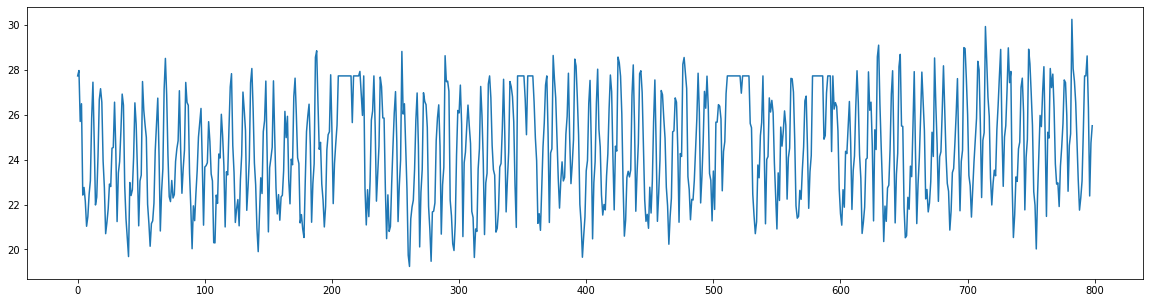

In [6]:
plt.figure(figsize=(20,5))
sns.lineplot([x for x in range(len(series))], series_arr)
plt.show()

## Bidirectional LSTM Model

In [7]:
x_train, y_train = X[:-24], y[:-24]
x_test, y_test = X[-24:], y[-24:]

In [8]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional 

model = Sequential()
model.add(Bidirectional(LSTM(100,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2]))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100,input_shape=(x_train.shape[1],x_train.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer="adam",loss="mse")

history = model.fit(x_train, y_train, epochs=50, batch_size=12, validation_split=0.2, shuffle=True)

2021-09-24 17:11:51.665547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-24 17:11:51.665586: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-24 17:11:53.354710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-24 17:11:53.354741: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-24 17:11:53.354762: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (winston-manjaro): /proc/driver/nvidia/version does not exist
2021-09-24 17:11:53.355032: I tensorflow/core/platform/cpu_fe

Epoch 1/50
51/51 [==============================] - 7s 34ms/step - loss: 115.7386 - val_loss: 6.3844
Epoch 2/50
51/51 [==============================] - 1s 15ms/step - loss: 6.6310 - val_loss: 5.6158
Epoch 3/50
51/51 [==============================] - 1s 15ms/step - loss: 6.5853 - val_loss: 5.6089
Epoch 4/50
51/51 [==============================] - 1s 15ms/step - loss: 6.4771 - val_loss: 5.7008
Epoch 5/50
51/51 [==============================] - 1s 15ms/step - loss: 6.6971 - val_loss: 5.6376
Epoch 6/50
51/51 [==============================] - 1s 16ms/step - loss: 6.7659 - val_loss: 5.6074
Epoch 7/50
51/51 [==============================] - 1s 15ms/step - loss: 6.7232 - val_loss: 5.8489
Epoch 8/50
51/51 [==============================] - 1s 15ms/step - loss: 6.5470 - val_loss: 5.6374
Epoch 9/50
51/51 [==============================] - 1s 16ms/step - loss: 6.6090 - val_loss: 5.6959
Epoch 10/50
51/51 [==============================] - 1s 17ms/step - loss: 6.8215 - val_loss: 5.6640
Epoch 1

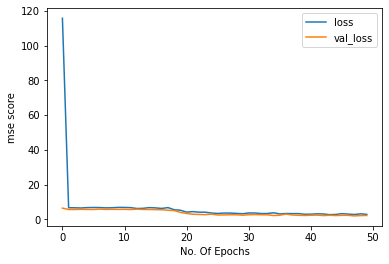

In [19]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")
plt.show()

In [12]:
y_pred = model.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse_lstm)


1.42485474075463


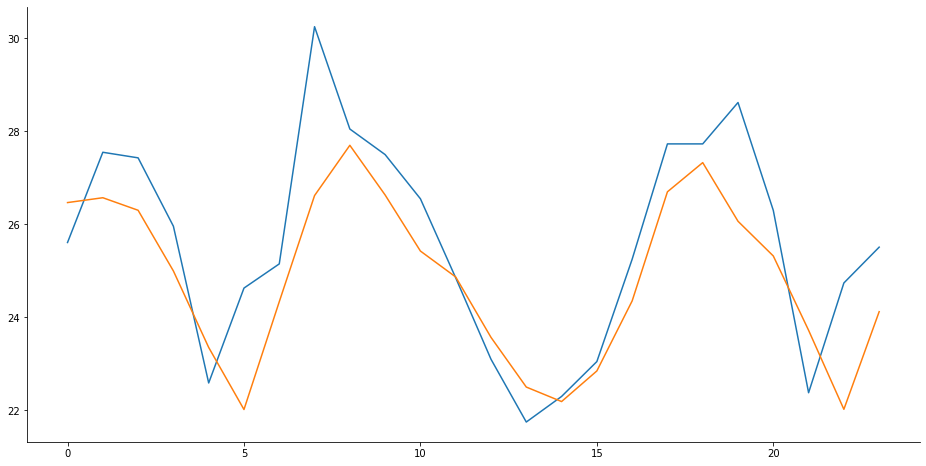

In [20]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
plt.plot(y_pred, label='predicted')
sns.despine()
plt.show()